In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import matplotlib as mpl
from time import time
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,binarize,MinMaxScaler,RobustScaler,Binarizer
from sklearn.feature_selection import mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC,SVC
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,average_precision_score
from sklearn.metrics import log_loss,roc_curve,classification_report,confusion_matrix,make_scorer
import warnings
warnings.filterwarnings("ignore")

### Creación de funciones

* La función plot_pie fué extraída de un notebook en Kaggle (sin referencia por el momento)


* El resto de las funciones fueron creadas por mi para simplificarme algunas tareas repetitivas y/o que la función entregue la interpretación del test directamente

In [2]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')
    
def get_hist(var1,var2,values_range=[0,1],nbins=20,normed=True,name_image='2hist.png'):
    
    common_params = dict(bins=nbins,range=values_range,normed=normed)
    plt.subplots_adjust(hspace=.8)
    plt.subplot(311)
    plt.title('Default')
    #plt.hist(df.popularity, **common_params)
    plt.hist(var1, **common_params)
    plt.hist(var2, **common_params)
    plt.subplot(312)
    plt.title('Skinny shift - 2 at a time')
    plt.hist((var1, var2), **common_params)
    plt.subplot(313)
    common_params['histtype'] = 'step'
    plt.title('With steps')
    #plt.hist(df.popularity, **common_params)
    plt.hist(var1, **common_params)
    plt.hist(var2, **common_params)

    plt.savefig(name_image)
    plt.show()

def expected_values(var1,var2):
    contingencyTable = pd.crosstab(index=var1,columns=var2,margins=True)
    expected =  np.outer(contingencyTable.iloc[0:(len(contingencyTable.index)-1)]['All'],
                         contingencyTable.loc["All"][0:(len(contingencyTable.columns)-1)]/contingencyTable.loc["All"]['All'])
    expected = pd.DataFrame(expected)
    expected.columns = contingencyTable.columns[0:(len(contingencyTable.columns)-1)]
    expected.index = contingencyTable.index[0:(len(contingencyTable.index)-1)]
    return expected

def chi2_test(var1,var2,alpha=0.99):
    #Creamos la tabla de contingencia con los valores totales
    contingencyTable = pd.crosstab(index=var1,columns=var2,margins=True)
    #Creamos la tabla de valores esperados
    expected =  np.outer(contingencyTable.iloc[0:(len(contingencyTable.index)-1)]['All'],
                         contingencyTable.loc["All"][0:(len(contingencyTable.columns)-1)]/contingencyTable.loc["All"]['All'])
    expected = pd.DataFrame(expected)
    expected.columns = contingencyTable.columns[0:(len(contingencyTable.columns)-1)]
    expected.index = contingencyTable.index[0:(len(contingencyTable.index)-1)]
    #Creamos la tabla de contingencia sin los valores totales
    contingencyTable = pd.crosstab(index=var1,columns=var2)
    #calculamos el valor calculado de chi2
    chi_squared_stat = (((contingencyTable-expected)**2)/expected).sum().sum()
    #calculamos los grados de libertad
    dof=(len(contingencyTable.columns)-1)*(len(contingencyTable.index)-1)
    #calculamos el valor crítico de chi2
    crit = sp.stats.chi2.ppf(q = alpha,df = dof)
    #calulamos el p-valor
    p_value = 1 - sp.stats.chi2.cdf(x=chi_squared_stat,df=dof)
    #testeamos la hipótesis nula de independencia entre las variables
    if(chi_squared_stat<=crit):
        print('no hay evidencia suficiente para rechazar H0, los valores son independientes y el p-valor es: {}'
              '\n el p-valor es:'.format(round(p_value,4)))
        #print("los valores esperados son: "+ str(expected))
    else:
        print('Se rechaza H0, no hay evidencia para decir que los valores son independientes'
              '\n y el p-valor es: {}'.format(round(p_value,4)))
        #print("los valores esperados son: "+ str(expected))


In [3]:
def train_classifier(X_train, y_train, X_test, models,scoring,probs=False):
    #create table to compare the metrics between each model
    compare_table_columns = [
    'Algorithm', 'Test average-precision','Test Accuracy Mean',
    'Test Accuracy 3*STD','Test F1','Test Recall','Parameters','Time']
    compare_table = pd.DataFrame(columns = compare_table_columns)
    #create table to compare predictions between each model
    compare_table_predict= {'real values': {'prediction':[list(y_train)]}}
    row_index = 0
    for alg in models:
        #set name and parameters
        table_name = alg.__class__.__name__
        compare_table.loc[row_index, 'Algorithm'] = table_name
        compare_table.loc[row_index, 'Parameters'] = str(alg.get_params())
        
        #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
        cv_results = cross_validate(estimator=alg,X=X_train,scoring=scores,y=y_train, 
                                    cv = 10,return_train_score=False)
        compare_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
        compare_table.loc[row_index, 'Test average-precision'] = cv_results['test_average-precision'].mean()
        compare_table.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_accuracy'].mean()   
        #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
        compare_table.loc[row_index, 'Test Accuracy 3*STD'] = cv_results['test_accuracy'].std()*3   #let's know the worst that can happen!
        compare_table.loc[row_index, 'Test Recall'] = cv_results['test_recall'].mean() 
        compare_table.loc[row_index, 'Test F1'] = cv_results['test_F1'].mean()
        #compare_table.loc[row_index, 'Test Roc-Auc Mean'] = cv_results['test_roc-auc-score'].mean()

        #save predictions
        alg.fit(X_train, y_train)
        compare_table_predict.update({table_name: {'prediction':alg.predict(X_test)} })
        
        row_index+=1
    
    return [compare_table,compare_table_predict]

In [26]:
def test_classifier(X_train, y_train, X_test, y_test, classifier,probs=False):
    classifier_name = str(type(classifier).__name__)
    print("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    print("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    print("Predicting values time {0}s".format(time() - now))
    if(probs):
        now = time()
        probs_prediction= model.predict_proba(X_test)
        print("Predicting probs time {0}s".format(time() - now))
        roc_auc   = roc_auc_score(y_test, probs_prediction[:,1])
    
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall    = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy  = accuracy_score(y_test, predictions)
    f1score   = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    cr        = classification_report(y_test, predictions)
    cm        = pd.crosstab(y_test, predictions, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
    results   = {classifier_name: 
                 {
                     'F1':f1score,
                     'Precision':precision,
                     'Recall':recall,
                     'Accuracy':accuracy,
                 }
                }
    if(probs):
        results.update({classifier_name: {
            'F1':f1score,
            'Precision':precision,
            'Recall':recall,
            'Accuracy':accuracy,
            'Roc-Auc':roc_auc} })
        return [results,cr,cm, predictions, probs_prediction]
    else:
        return [results,cr,cm,predictions]

### Extracción y comprensión de la data

* El fragmento siguiente carga el conjunto de datos de inicio de diabetes de los indios Pima

* Link a los datos *<https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes>*

In [4]:
url = "diabetes.csv"
#names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'clas']
df = pd.read_csv(url)
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


1. Pregnancies: Number of times pregnant
2. Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test 3. Diastolic blood pressure (mm Hg)
3. BloodPressure: sistolic presion
4. SkinThinkness: Triceps skin fold thickness (mm)
5. Insulin: 2-Hour serum insulin (mu U/ml)
6. BMI: Body mass index (weight in kg/(height in m)ˆ2)
7. DiabetesPedigreeFunction: Diabetes pedigree function
8. Age:  Age (years)
9. Outcome: Class variable (0 or 1)

### Corrección de anomalías

* Corrección de anomalía: la existencia de valores 0 en variables donde no es posible que existan, como por ejemplo: presión sanguinea, concentración de glucosa, nivel de insulina en la sangre, etc. Dado que se desconoce el origen de este error, se tomarán estos valores como NA's y por lo tanto se genera la conversión para luego volver a revisar los datos

In [5]:
df['Glucose'] = df['Glucose'].replace(0, np.nan)
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan)
df['Insulin'] = df['Insulin'].replace(0, np.nan)
df['BMI'] = df['BMI'].replace(0, np.nan)

* Observamos que la mayor cantidad de NA's están en las variables que entregan los valores de concentración de insulina y espesor de la piel. Antes de decidir cómo se resolverá este problema, vamos a comprender la relación de las variables entre ellas y con la presencia de diabetes 


* La presión sanguinea, BMI y glucosa presentan menos de un 5% de valores NA's, sin embargo dado lo pequeña de la muestra, intentaremos minimizar al máximo la eliminación de datos 

In [6]:
qna=df.shape[0]-df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qna, 'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

,Na en %,datos sin NAs en q
Insulin,48.70,394
SkinThickness,29.56,541
BloodPressure,4.56,733
BMI,1.43,757
Glucose,0.65,763
Pregnancies,0.00,768
DiabetesPedigreeFunction,0.00,768
Age,0.00,768
Outcome,0.00,768


### Eliminación de variables

* Se eliminan las variables de insulina y espesor de la piel ya que presentan una alta proporción de valores NAs y están fuertemente correlacionadas con las variables de Glucosa y BMI, como se puede observar en los gráficos que se mostraron arriba



* Dado que la variable BloodPressure tiene 35(5%) NAs y es la variable con menor relevancia/impacto (medida por mutual information y por importancia de las variables según RFE y Random Forest) para explicar la presencia de diabetes, se decide eliminar la presión sistólica como variable

In [7]:
del df['Insulin']
del df['SkinThickness']

### Eliminación de NA's y transformación de variables

* Una vez realizadas las eliminaciones de variables se procede a eliminar los 6 registros que continen NA's de la variable BMI

* Luego se realiza 

In [8]:
df=df.dropna().copy()
df.loc[:,'DiabetesPedigreeFunction']=MinMaxScaler().fit_transform(df[['DiabetesPedigreeFunction']])
df.loc[:,'Age']=MinMaxScaler().fit_transform(df[['Age']])
df.loc[:,'Glucose']=MinMaxScaler().fit_transform(df[['Glucose']])
df.loc[:,'BMI']=MinMaxScaler().fit_transform(df[['BMI']])
df.loc[:,'Pregnancies']=MinMaxScaler().fit_transform(df[['Pregnancies']])
X=df.loc[:, df.columns != 'Outcome']
Y=df.Outcome.values.ravel()

## Modelamiento

### Estructura del dataset

* Para entrenar el modelo vamos a dividir el dataset de forma aleatoria en un 70% para entrenar y un 30% para testear, de tal forma que las proporciones de las clases se mantengan constantes


* Para atacar el problema de balance de clases,usaremos las técnicas SMOTE y RandomUnderSample


* Se tendrá especial cuidado en usar la técnica de balance de clases solo para los datos de entrenamiento, ya que los datos de test siempre deben estar sin manipulación de este tipo

Información del dataset:
 las clases del target son: Counter({0: 332, 1: 174})


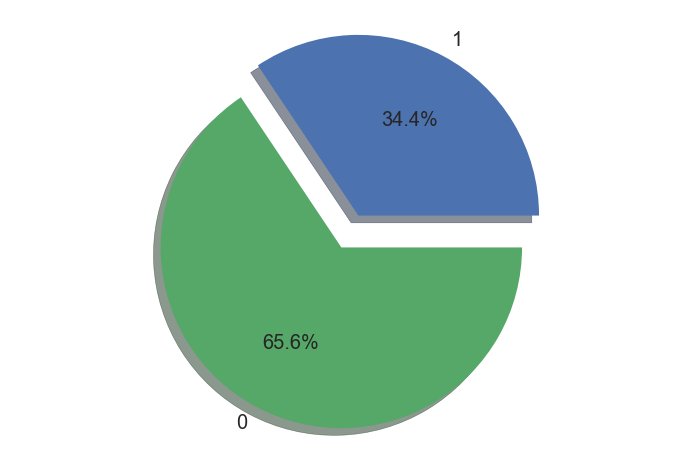

In [9]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=0,test_size=0.3,stratify=Y)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train)))
plot_pie(y_train)

Información del dataset con Random Under Sampling:
 y: Counter({0: 174, 1: 174})


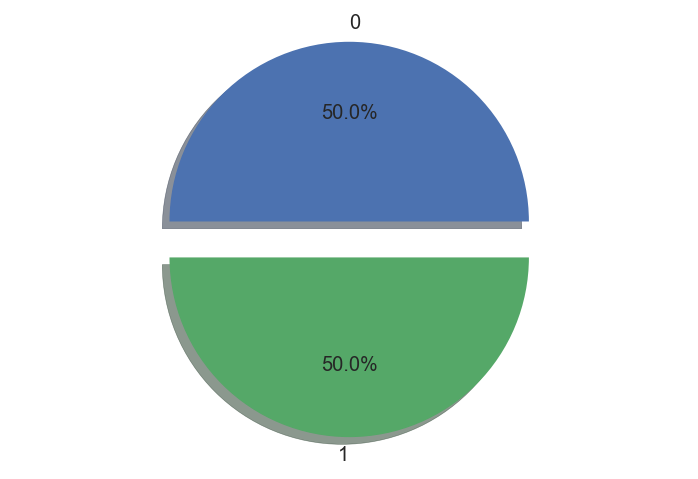

In [10]:
X_train_us, y_train_us , index_us= RandomUnderSampler(
    ratio='not minority', random_state=0,return_indices=True
).fit_sample(X_train, y_train)
print('Información del dataset con Random Under Sampling:'
      '\n y: {}'.format(Counter(y_train_us)))
plot_pie(y_train_us)

Información del dataset aplicando el algoritmo Smote:
 y: Counter({1: 332, 0: 332})


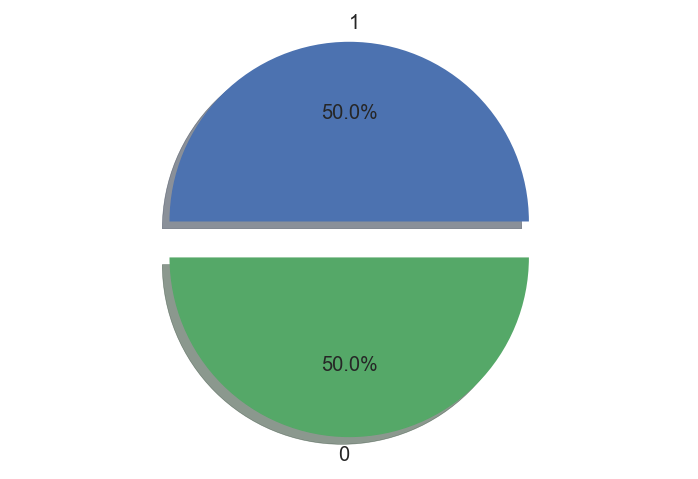

In [11]:
sm = SMOTE(random_state=0,n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print('Información del dataset aplicando el algoritmo Smote:'
      '\n y: {}'.format(Counter(y_train_res)))
plot_pie(y_train_res)

In [12]:
scores={'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall':make_scorer(recall_score),
        'F1':make_scorer(f1_score),
        #'roc-auc-score':make_scorer(roc_auc_score),
        'average-precision':'average_precision'}

In [13]:
# Functions to restart the classifiers with the the best parameters selected for each model
def restart_classifiers():
    
    classifier_LR = LogisticRegression(warm_start=True,random_state=0,max_iter=300)
    
    classifier_RF = RandomForestClassifier(
        n_estimators=300,random_state=0,warm_start=True,criterion='gini',bootstrap=True,max_features='sqrt',
        min_samples_leaf=22,min_samples_split=22
    )
    
    classifier_linearSVC=LinearSVC(random_state=0,dual=True,penalty='l2',C=1,loss='squared_hinge')
    
    classifier_SVC = SVC(kernel='rbf',probability=True,max_iter=300,random_state=0)
    
    classifier_GB = GradientBoostingClassifier(
        random_state=0,subsample=0.8,n_estimators=300,presort=True,learning_rate=0.05,max_features='sqrt',
        min_samples_split=22,min_samples_leaf=22
    )
    
    classifier_KNN = KNeighborsClassifier()
    
    classifier_DT = DecisionTreeClassifier(random_state=0)
    
    classifier_AB = AdaBoostClassifier(random_state=0)
    
    algorithms=[classifier_LR,classifier_RF,classifier_linearSVC,classifier_SVC,classifier_GB,classifier_KNN,
               classifier_DT,classifier_AB]
    
    return algorithms

In [14]:
algorithms=restart_classifiers()
results, predictions=train_classifier(
    X_train=X_train,y_train=y_train,X_test=X_test,models=algorithms,scoring=scores)
results.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
1,RandomForestClassifier,0.719654,0.756825,0.170001,0.584936,0.499673,"{'bootstrap': True, 'class_weight': None, 'cri...",0.754309
0,LogisticRegression,0.719459,0.752597,0.133336,0.557558,0.45915,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.0031208
4,GradientBoostingClassifier,0.696918,0.746867,0.199723,0.60475,0.557843,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.271074
7,AdaBoostClassifier,0.664297,0.736944,0.204232,0.597421,0.557516,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.0949439
6,DecisionTreeClassifier,0.474248,0.691834,0.235064,0.555951,0.558497,"{'class_weight': None, 'criterion': 'gini', 'm...",0.00246782
2,LinearSVC,0.718434,0.683525,0.198707,0.410356,0.448366,"{'C': 1, 'class_weight': None, 'dual': True, '...",0.0196943
5,KNeighborsClassifier,0.47507,0.655834,0.135807,0.395193,0.344771,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.00148134
3,SVC,0.5046,0.640299,0.0627429,0,0,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.0302727


In [15]:
algorithms=restart_classifiers()
results_res, predictions_res=train_classifier(
    X_train=X_train_res,y_train=y_train_res,X_test=X_test,models=algorithms,scoring=scores)
results_res.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_res

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
4,GradientBoostingClassifier,0.854054,0.789305,0.176322,0.788633,0.804991,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.405168
1,RandomForestClassifier,0.850615,0.779947,0.141626,0.788062,0.816578,"{'bootstrap': True, 'class_weight': None, 'cri...",0.610439
0,LogisticRegression,0.816039,0.754278,0.15617,0.750586,0.740642,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.00213752
7,AdaBoostClassifier,0.807119,0.754144,0.20423,0.761996,0.789216,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.240252
5,KNeighborsClassifier,0.760935,0.739661,0.21329,0.755826,0.822727,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.00094521
6,DecisionTreeClassifier,0.677693,0.736809,0.24329,0.734658,0.75098,"{'class_weight': None, 'criterion': 'gini', 'm...",0.00340662
2,LinearSVC,0.816347,0.649109,0.263284,0.708948,0.864795,"{'C': 1, 'class_weight': None, 'dual': True, '...",0.0285611
3,SVC,0.705458,0.632308,0.191703,0.648664,0.680838,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.0534746


In [16]:
algorithms=restart_classifiers()
results_us, predictions_us=train_classifier(
    X_train=X_train_us,y_train=y_train_us,X_test=X_test,models=algorithms,scoring=scores)
results_us.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_us

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
4,GradientBoostingClassifier,0.798126,0.726307,0.196791,0.734238,0.759477,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.222402
0,LogisticRegression,0.801479,0.715196,0.12465,0.713449,0.718301,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.00337884
1,RandomForestClassifier,0.809703,0.70866,0.205836,0.714953,0.741176,"{'bootstrap': True, 'class_weight': None, 'cri...",0.814132
7,AdaBoostClassifier,0.775793,0.702614,0.293259,0.700278,0.689869,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.0903708
6,DecisionTreeClassifier,0.599744,0.635784,0.304028,0.633621,0.630392,"{'class_weight': None, 'criterion': 'gini', 'm...",0.00200684
5,KNeighborsClassifier,0.640757,0.627941,0.215854,0.611618,0.596078,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.00169382
2,LinearSVC,0.794509,0.594444,0.200691,0.459711,0.428758,"{'C': 1, 'class_weight': None, 'dual': True, '...",0.0143912
3,SVC,0.595838,0.539706,0.187894,0.571665,0.647386,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.01802


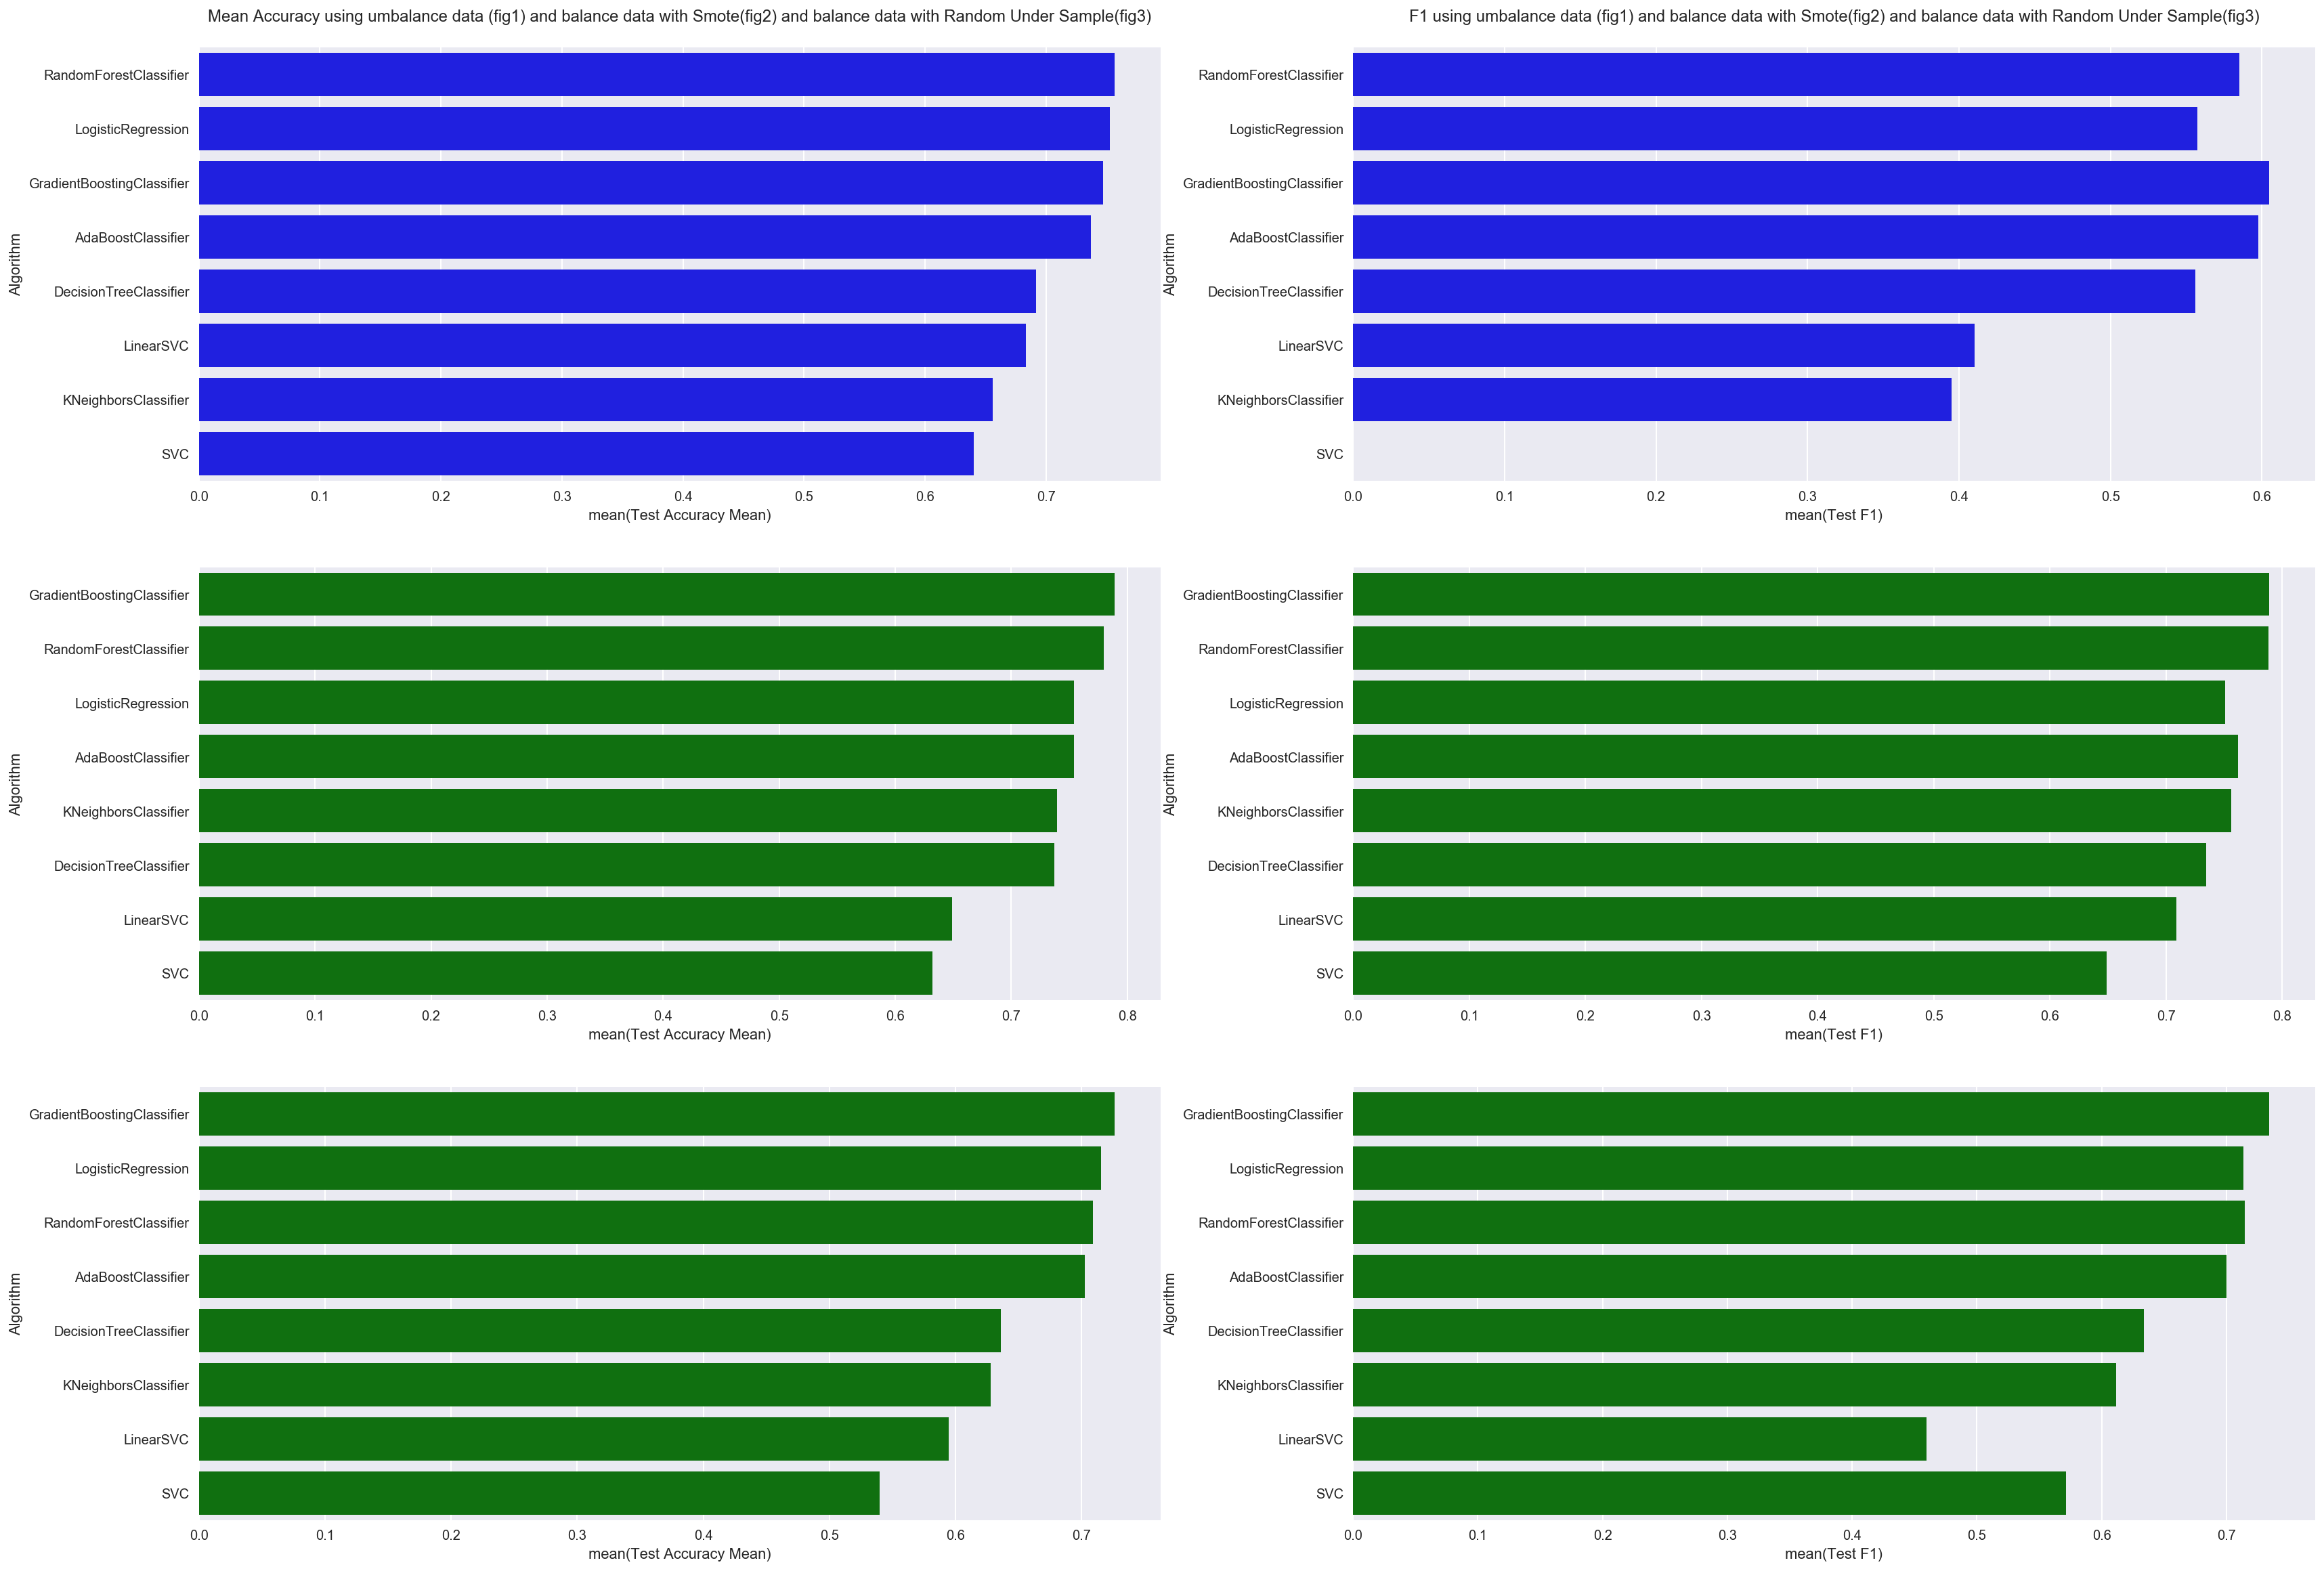

In [17]:
fig, axis = plt.subplots(3, 2,figsize=(28,20))
axis[0,0].set_title('Mean Accuracy using umbalance data (fig1) and balance data with Smote(fig2) and balance data with Random Under Sample(fig3)\n')
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results, color = 'b',ax = axis[0,0])
sns.barplot(x='Test F1', y = 'Algorithm', data = results, color = 'b',ax = axis[0,1])
axis[0,1].set_title('F1 using umbalance data (fig1) and balance data with Smote(fig2) and balance data with Random Under Sample(fig3)\n')
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_res, color = 'g',ax = axis[1,0])
sns.barplot(x='Test F1', y = 'Algorithm', data = results_res, color = 'g',ax = axis[1,1]);
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_us, color = 'g',ax = axis[2,0])
sns.barplot(x='Test F1', y = 'Algorithm', data = results_us, color = 'g',ax = axis[2,1]);

### Resultados iniciales y optimización de parámetros

* Como podemos ver, los mejores resultados los obtenemos cuando aplicamos al técnica de balance Smote y los algoritmos de Gradient Boosting, Random Forest y Regresión logística. 


* Ahora, aplicaremos una optmización de parámetros en el entrenamiento de los 3 algoritmos con el objetivo de seleccionar el que entregue el mejor resultado en sus predicciones. Para ello, utilizaremos el Accuracy como métrica para determinar los mejores parámetros utilizando el algoritmo GridsearchCV


* References: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [18]:
# Functions to select the best parameters for each model

# This function creates all the classifiers that will be used
def create_classifiers():
    classifier_LR = LogisticRegression(random_state=0,max_iter=300,warm_start=True)
    classifier_RF = RandomForestClassifier(bootstrap=True,n_estimators=300,random_state=0,n_jobs=-1,
                                           warm_start=True)
    classifier_GB = GradientBoostingClassifier(random_state=0,subsample=0.8,n_estimators=300,presort=True,
                                               warm_start=True,learning_rate=0.01)
    algorithms=[classifier_LR,classifier_RF,classifier_GB]
    
    return algorithms

# This function creates the parameters which will be tested for each algorithm
def create_parameters():
    parameters_LR = {'C':[0.01,0.1,0.5,1,5,10]}
    parameters_RF = {'criterion':['gini','entropy'],'max_features':['sqrt','auto','log2'],
                     'min_samples_split':[15,25],'min_samples_leaf':[15,25]}

    parameters_GB = {'max_features':['sqrt','auto','log2'],'min_samples_split':[12,20],
                     'min_samples_leaf':[12,20],'learning_rate':[0.01,0.05]}
    
    parameters=[parameters_LR,parameters_RF,parameters_GB]
    
    return parameters

# This function execute the GridsearchCV with for all the algorithms wich the parameters given and return
# the main metrics for binary classification problems and the best parameters 
def get_best_param(X_train,y_train,classifiers):
    params_metrics={}
    for i in range(0,len(classifiers)):
        classifiers[i].fit(X_train,y_train)
        params_metrics.update({classifiers[i].estimator.__class__.__name__:
                 {
                  'accuracy':classifiers[i].cv_results_.get('mean_test_accuracy')[classifiers[i].best_index_],
                  #'precision':classifiers[i].cv_results_.get('mean_test_precision')[classifiers[i].best_index_],
                  #'F1':classifiers[i].cv_results_.get('mean_test_F1')[classifiers[i].best_index_],
                  #'recall':classifiers[i].cv_results_.get('mean_test_recall')[classifiers[i].best_index_],
                  #'roc-auc':classifiers[i].cv_results_.get('mean_test_roc-auc-score')[classifiers[i].best_index_],
                  'best_params':classifiers[i].best_params_
                 }
                })
        
    return params_metrics

In [19]:
scores={'accuracy': make_scorer(accuracy_score)}
parameters=create_parameters()

In [20]:
algorithms=create_classifiers()
clf=[]
for i in range(0,len(algorithms)):
    clf.append(GridSearchCV(estimator=algorithms[i], param_grid=parameters[i],cv=10,scoring=scores,refit='accuracy')) 
best_parameters_res=get_best_param(X_train=X_train_res,y_train=y_train_res,classifiers=clf);

In [21]:
best_parameters_res

{'GradientBoostingClassifier': {'accuracy': 0.7996987951807228,
  'best_params': {'learning_rate': 0.05,
   'max_features': 'auto',
   'min_samples_leaf': 12,
   'min_samples_split': 12}},
 'LogisticRegression': {'accuracy': 0.7545180722891566,
  'best_params': {'C': 1}},
 'RandomForestClassifier': {'accuracy': 0.7816265060240963,
  'best_params': {'criterion': 'gini',
   'max_features': 'sqrt',
   'min_samples_leaf': 15,
   'min_samples_split': 15}}}

### Entrenamiento

* Se utilizaran 3 modelos para entrenar utilizando validación cruzada con k=10 y el dataset de entrenamiento balanceado con el algoritmo Smote


* Se evaluaran todas las métricas de clasificación y se escogerá aquel modelo que obtenga el mejor balance de ellas. Sin embargo, las principales serán el Accuracy y el F1. Sin embargo, al momento de escoger el modelo tendremos siempre en cuenta que si debemos hacer un trafe off, preferimos tener falsos positivos que falsos negativos 


* Para los algoritmos de Random Forest y Gradient Boosting se restringe la mínima cantiad de datos para que los árboles hagan split, para que se cree un nodo final y la máxima cantidad de features. Todo esto con el objetivo de disminuir el riesgo de sobre-ajuste. Al GB también se le indica que tome muestras del 80% para construir los árboles, de tal forma que el algoritmo no se aprenda los datos de memoria en la medida que va haciendo la convergencia

In [22]:
# Functions to restart the classifiers with the the best parameters selected for each model

def restart_classifiers(best_parameters):
    
    classifier_LR = LogisticRegression(
        random_state=0,max_iter=300,warm_start=True,class_weight=None,
        C=best_parameters.get('LogisticRegression').get('best_params').get('C'),
    )
    
    classifier_RF = RandomForestClassifier(
        n_estimators=300,random_state=0,n_jobs=-1,bootstrap=True,warm_start=True,
        criterion=best_parameters.get('RandomForestClassifier').get('best_params').get('criterion'),
        max_features=best_parameters.get('RandomForestClassifier').get('best_params').get('max_features'),
        min_samples_split=best_parameters.get('RandomForestClassifier').get('best_params').get('min_samples_split'),
        min_samples_leaf=best_parameters.get('RandomForestClassifier').get('best_params').get('min_samples_leaf')
      
    )
    
    
    classifier_GB = GradientBoostingClassifier(
        random_state=0,subsample=0.8,n_estimators=300,presort=True,warm_start=True,
        max_features=best_parameters.get('GradientBoostingClassifier').get('best_params').get('max_features'),
        min_samples_split = best_parameters.get('GradientBoostingClassifier').get('best_params').get('min_samples_split'),
        min_samples_leaf = best_parameters.get('GradientBoostingClassifier').get('best_params').get('min_samples_leaf'),
        learning_rate=best_parameters.get('GradientBoostingClassifier').get('best_params').get('learning_rate'),
    )
    
    
    algorithms=[classifier_LR,classifier_RF,classifier_GB]
    
    return algorithms

In [23]:
scores={'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall':make_scorer(recall_score),
        'F1':make_scorer(f1_score),
        'roc-auc-score':make_scorer(roc_auc_score),
        'average-precision':'average_precision'
       }

In [24]:
algorithms=restart_classifiers(best_parameters_res)
results_res, predictions_res=train_classifier(
    X_train=X_train_res,y_train=y_train_res,X_test=X_test,models=algorithms,scoring=scores)
results_res.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_res

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
2,GradientBoostingClassifier,0.853647,0.799599,0.210878,0.802429,0.828788,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.320452
1,RandomForestClassifier,0.851278,0.781595,0.14412,0.789682,0.819608,"{'bootstrap': True, 'class_weight': None, 'cri...",0.798026
0,LogisticRegression,0.816039,0.754278,0.15617,0.750586,0.740642,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.00189826


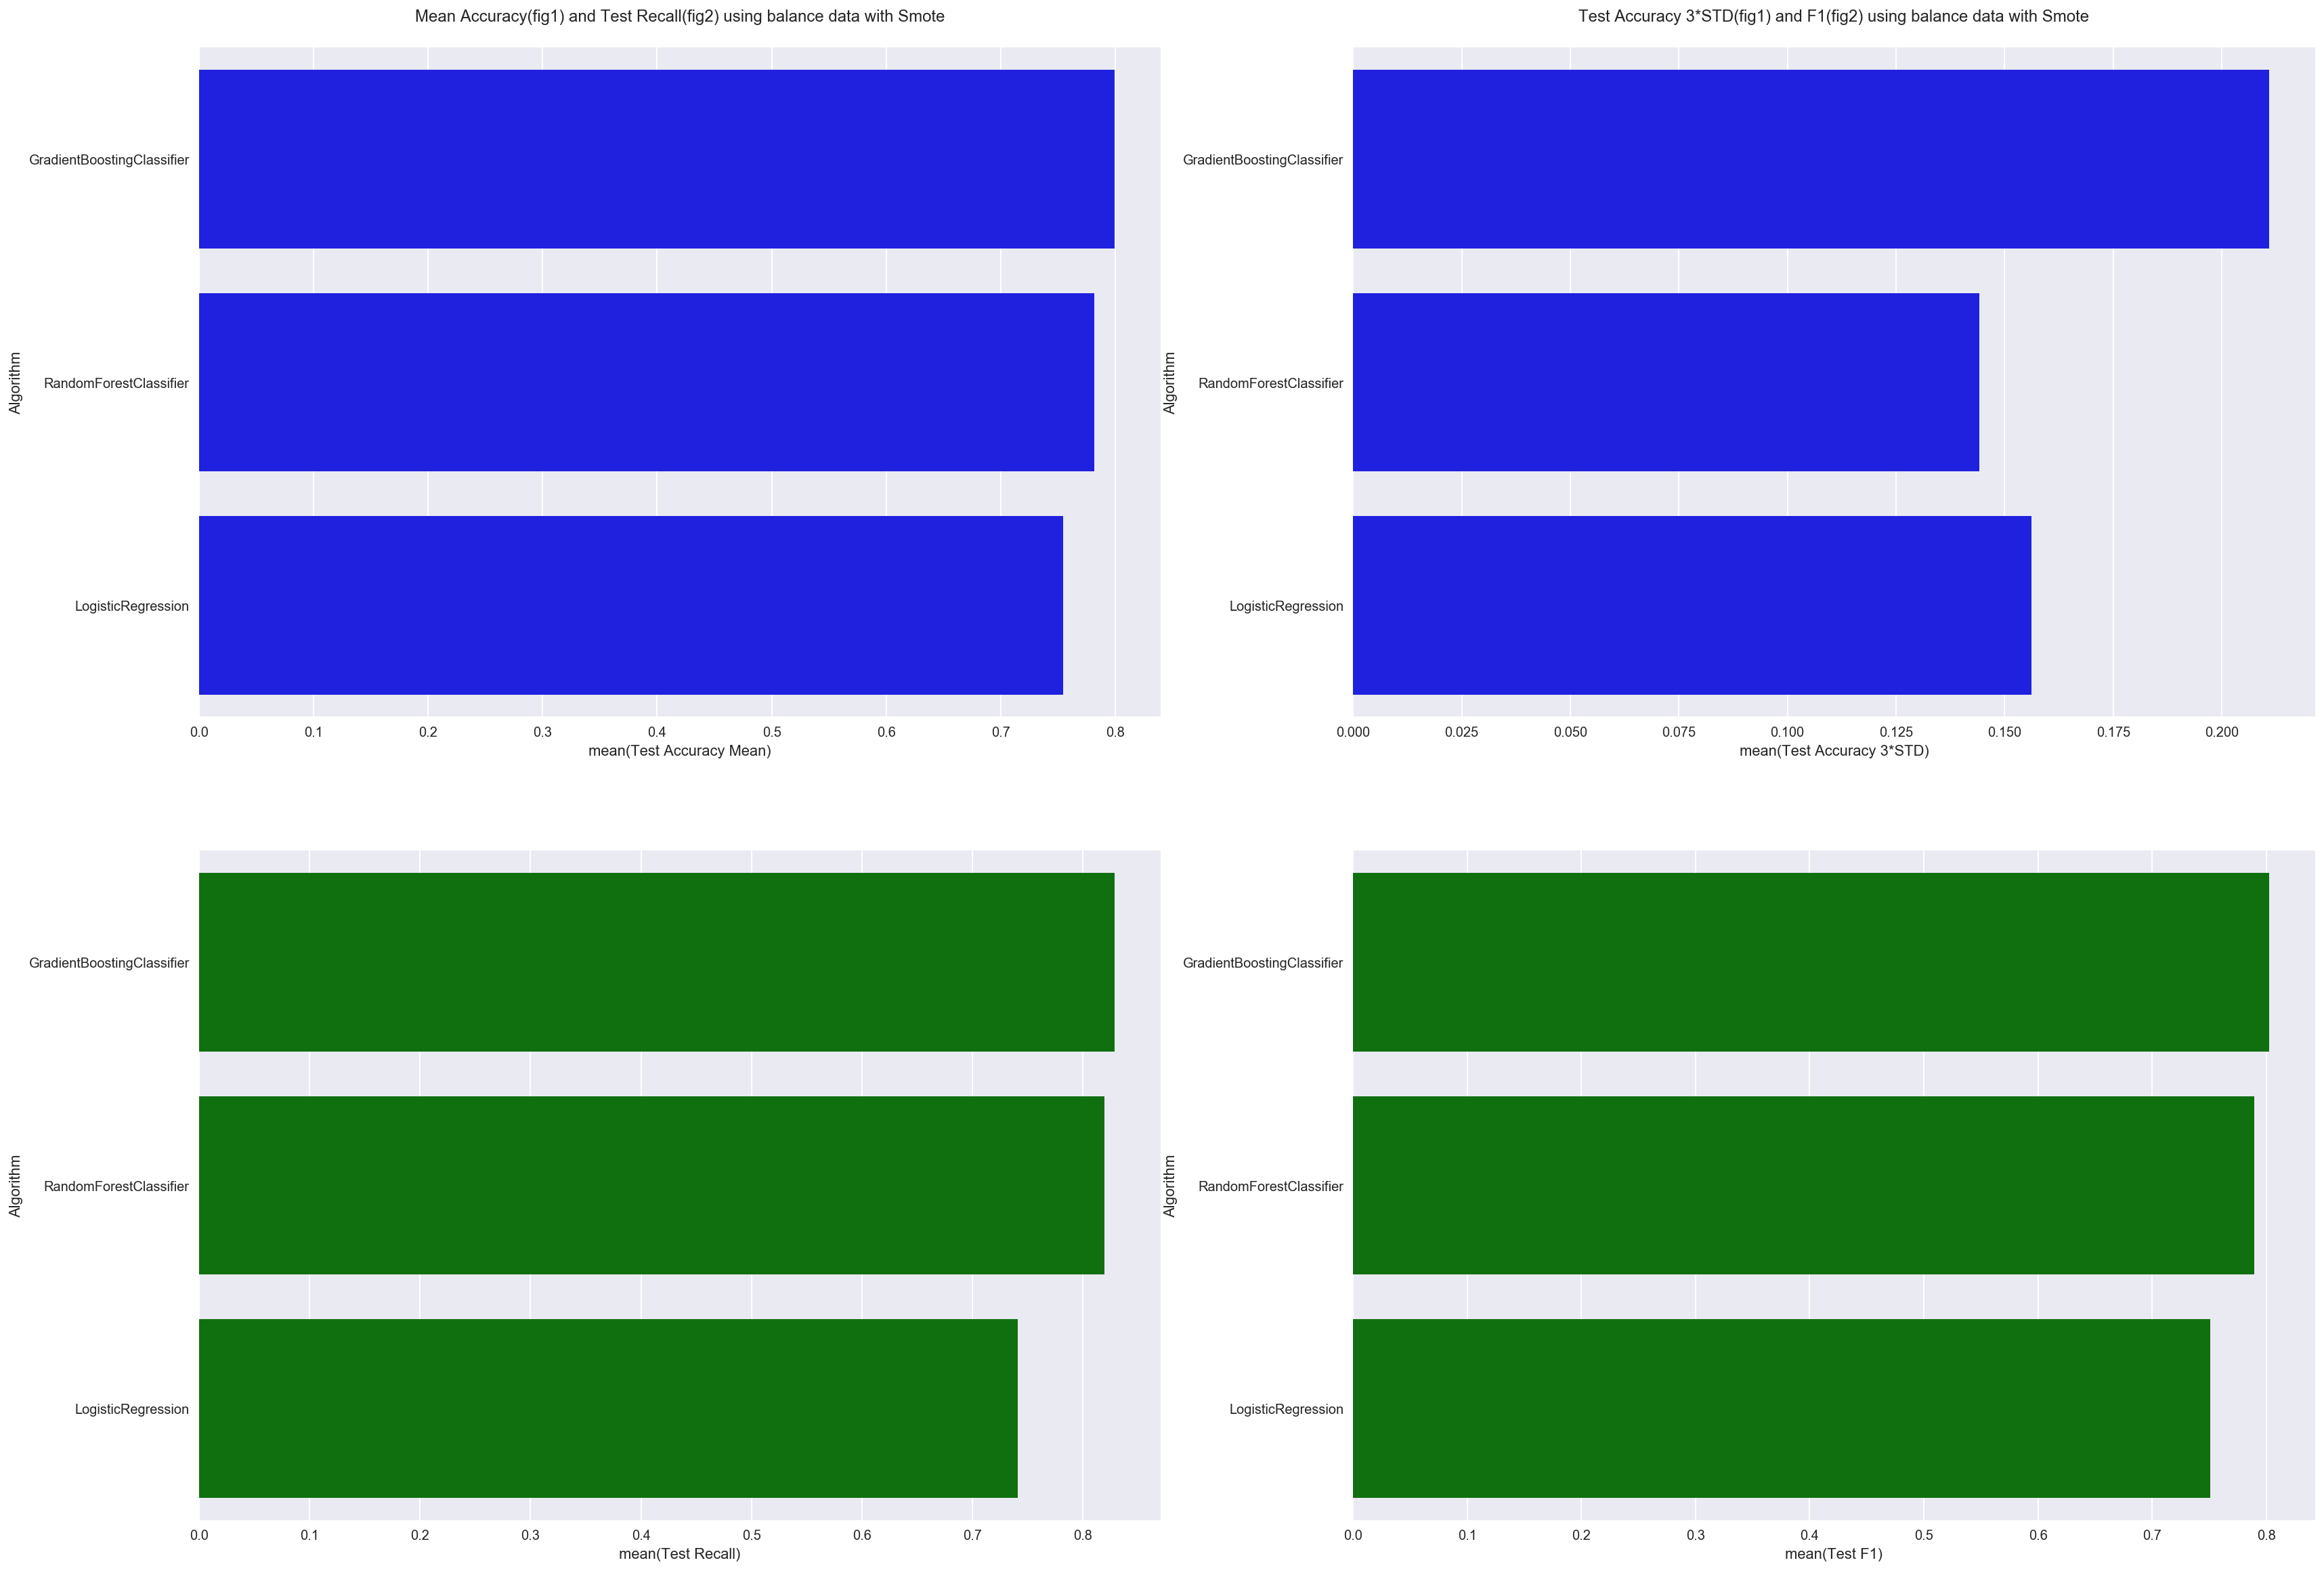

In [25]:
fig, axis = plt.subplots(2, 2,figsize=(28,20))
axis[0,0].set_title('Mean Accuracy(fig1) and Test Recall(fig2) using balance data with Smote\n')
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_res, color = 'b',ax = axis[0,0])
sns.barplot(x='Test Accuracy 3*STD', y = 'Algorithm', data = results_res, color = 'b',ax = axis[0,1])
axis[0,1].set_title('Test Accuracy 3*STD(fig1) and F1(fig2) using balance data with Smote\n')
sns.barplot(x='Test Recall', y = 'Algorithm', data = results_res, color = 'g',ax = axis[1,0])
sns.barplot(x='Test F1', y = 'Algorithm', data = results_res, color = 'g',ax = axis[1,1]);

# Test

* Escogemos los modelos de Random Forest y Regresión logística como los algoritmos seleccionados. Escogemos dos porque sabemos que dada la manera en que están construidos, los dos algoritmos funcionan de formas muy distintas y son capaces de capturar relaciones de distinta naturaleza, por lo que queremos validar con cuál algoritmo obtenemos mejores resultados sobre nuestro conjunto de test


* Utilizamos los datos de test sin balance de clases para testear nuestros modelos escogidos (Random Forest y Regresion logística) y optamos por quedarnos con la Regresión logística, con la cual obtenemos los siguientes resultados:

     * Accuracy: 79%
     * Roc auc score: 0.88
     * Sensitivity: 66%
     * Specificity: 89%
     * Recall de la clase positiva: 81%
     * Recall de la clase negativa: 78%


* El modelo es muy bueno identificando a los pacientes que no son diabéticos, pero tiene una performance menor para identificar a los que si lo son. Aún así, es el modelo con mejor balance en la precisión entre ambas clases, menor variabilidad en sus resultados y menor proproción de falsos negativos, que es el error que queremos minimizar.

In [29]:
algorithms[1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=True)

In [36]:
algorithms=restart_classifiers(best_parameters_res)
classifier_LR=algorithms[0]
classifier_RF=algorithms[1]
selected_models=[classifier_LR,classifier_RF]
results=[]
classif_report=[]
confusion_matrix=[]
preds=[]
probs_prediction=[]
for model in selected_models:
    aux,cr,cm,predictions, probs=test_classifier(
        X_train=X_train_res, y_train=y_train_res,X_test=X_test, 
        y_test=y_test,classifier=model,probs=True)
    results.append(aux)
    classif_report.append(cr)
    confusion_matrix.append(cm)
    preds.append(predictions)
    probs_prediction.append(probs)

Testing LogisticRegression
Learing time 0.004906892776489258s
Predicting values time 0.0004868507385253906s
Predicting probs time 0.00032210350036621094s
Testing RandomForestClassifier
Learing time 0.7659580707550049s
Predicting values time 0.10489606857299805s
Predicting probs time 0.1021261215209961s


In [37]:
print("Accuracy del Random Forest: {0}".format(results[1].get('RandomForestClassifier').get('Accuracy')))
print(classif_report[1])
confusion_matrix[1]

Accuracy del Random Forest: 0.7706422018348624
             precision    recall  f1-score   support

          0       0.83      0.82      0.82       143
          1       0.66      0.68      0.67        75

avg / total       0.77      0.77      0.77       218



Predicted class,0,1,All
Actual class,,,
0,117,26,143
1,24,51,75
All,141,77,218


In [38]:
print("Accuracy de la regresión logística: {0}".format(results[0].get('LogisticRegression').get('Accuracy')))
print(classif_report[0])
confusion_matrix[0]

Accuracy de la regresión logística: 0.7935779816513762
             precision    recall  f1-score   support

          0       0.89      0.78      0.83       143
          1       0.66      0.81      0.73        75

avg / total       0.81      0.79      0.80       218



Predicted class,0,1,All
Actual class,,,
0,112,31,143
1,14,61,75
All,126,92,218


0.8577156177156178


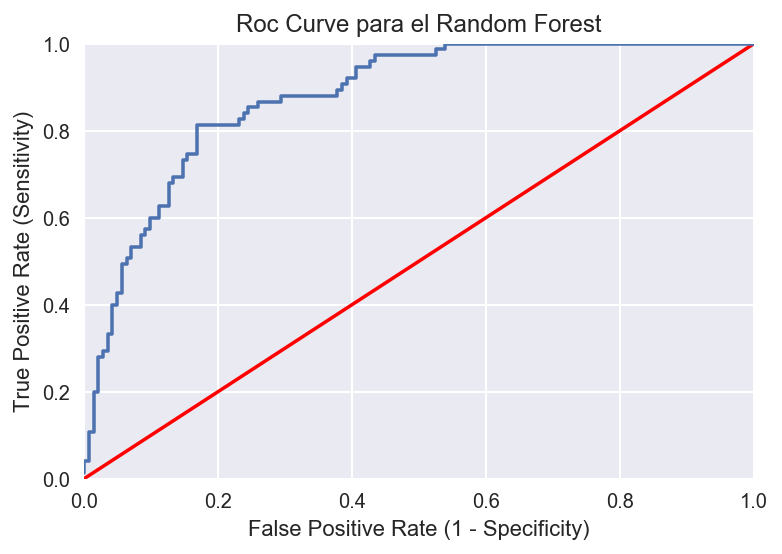

In [40]:
#Visualización de la curva ROC: equilibrio entre True (tpr) and False (fpr) Positive Rate
preds=binarize([probs_prediction[1][:,1]],0.5)[0]
print(results[1].get('RandomForestClassifier').get('Roc-Auc'))
line = np.linspace(0, 1, 2)
plt.plot(line, 'r')
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=probs_prediction[0][:,1],pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Roc Curve para el Random Forest')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True);

0.8788811188811189


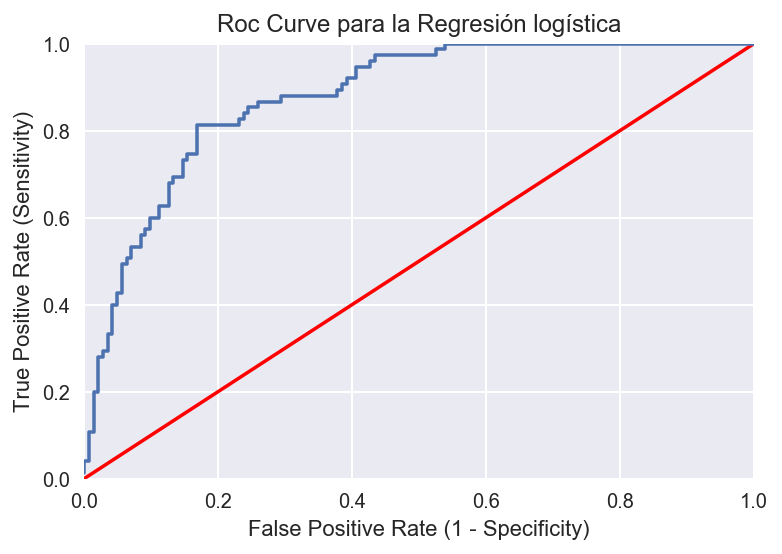

In [39]:
#Visualización de la curva ROC: equilibrio entre True (tpr) and False (fpr) Positive Rate
preds=binarize([probs_prediction[0][:,1]],0.5)[0]
print(results[0].get('LogisticRegression').get('Roc-Auc'))
line = np.linspace(0, 1, 2)
plt.plot(line, 'r')
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=probs_prediction[0][:,1],pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Roc Curve para la Regresión logística')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True);